# Corona Virus - Covid-19 Analysis and Forecast
- Inspired on the work of [Devakumar kp](https://www.kaggle.com/imdevskp/covid-19-analysis-viz-prediction-comparisons)
- by Marcelo Rovai
- 03 March 2020

## Main Libraries and setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly
import plotly.graph_objs as go
import folium

In [5]:
import itertools
from scipy import stats
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet

In [6]:
import warnings

In [7]:
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150
plotly.offline.init_notebook_mode(connected=True)

pd.options.display.float_format = '{:,}'.format

## Load Data

COVID-19 Complete Dataset (Updated every 24hrs) - Kaggle depository <br>
Number of Confirmed, Death and Recovered cases every day across the globe
- Day level information on covid-19 affected cases
- [COVID-19 Complete Dataset (Updated every 24hrs)](https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv)

**Context**

A new coronavirus designated 2019-nCoV was first identified in Wuhan, the capital of China's Hubei province, after people developed pneumonia without a clear cause and for which existing vaccines or treatments were not effective. The virus has shown evidence of human-to-human transmission, and its transmission rate (rate of infection) appeared to escalate in mid-January 2020, with several countries across Europe, North America, and the Asia Pacific reporting cases.

As of 30 January 2020, approximately 8,243 cases have been confirmed, including in every province of China. The first confirmed death from the coronavirus infection occurred on 9 January and since then 170 deaths have been confirmed.

- Data from [OMS Coronavirus disease (COVID-2019) daily situation reports](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)

**Column Description**
    - Province/State - Province or state of the observation (Could be empty when missing)
    - Country/Region - Country of observation
    - Lat - Latitude Geo - Referenciation of Province or Country
    - Long - Longitude Geo- Referenciation of Province or Country
    - Date - Date of the observation in MM/DD/YYYY
    - Confirmed - Cumulative number of confirmed cases till that date
    - Deaths - Cumulative number of of deaths till that date
    - Recovered - Cumulative number of recovered cases till that date


In [273]:
ls ../data

covid_19_clean_complete.csv


In [143]:
df = pd.read_csv('../data/covid_19_clean_complete.csv' )
df.shape

(5822, 8)

In [144]:
df.head(2)

Province/State  Country/Region     Lat     Long     Date  Confirmed  Deaths  \
0          Anhui  Mainland China 31.8257 117.2264  1/22/20          1       0   
1        Beijing  Mainland China 40.1824 116.4142  1/22/20         14       0   

   Recovered  
0          0  
1          0

In [145]:
df.tail(2)

Province/State Country/Region    Lat      Long    Date  Confirmed  \
5820  Sonoma County, CA             US 38.578 -122.9888  3/2/20          1   
5821       Umatilla, OR             US 45.775 -118.7606  3/2/20          1   

      Deaths  Recovered  
5820       0          0  
5821       0          0

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 8 columns):
Province/State    3075 non-null object
Country/Region    5822 non-null object
Lat               5822 non-null float64
Long              5822 non-null float64
Date              5822 non-null object
Confirmed         5822 non-null int64
Deaths            5822 non-null int64
Recovered         5822 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 364.0+ KB


In [147]:
df['Date'] = pd.to_datetime(df['Date'])

In [148]:
df['Country/Region'].value_counts()[:10]

Mainland China    1271
US                1189
Australia          287
Canada             164
Indonesia           41
Austria             41
Afghanistan         41
Denmark             41
Oman                41
Azerbaijan          41
Name: Country/Region, dtype: int64

In [149]:
df['Province/State'].value_counts()[:10]

Cook County, IL                                82
Portland, OR                                   41
Providence, RI                                 41
Diamond Princess cruise ship                   41
Shandong                                       41
Guangdong                                      41
Unassigned Location (From Diamond Princess)    41
San Mateo, CA                                  41
San Antonio, TX                                41
British Columbia                               41
Name: Province/State, dtype: int64

In [150]:
df['Country/Region'] = df['Country/Region'].replace('Mainland China', 'China')
df['Country/Region'] = df['Country/Region'].replace('Others', 'Ship Diam Princess')

In [151]:
df.isnull().sum()

Province/State    2747
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [152]:
df[['Province/State']] = df[['Province/State']].fillna('NA')

In [153]:
df['Deaths/Confirmed'] = round((gdf.Deaths/gdf.Confirmed)*100, 1)

In [154]:
df['Deaths/Confirmed'] = df['Deaths/Confirmed'].fillna(0)

In [155]:
df.head()

Province/State Country/Region     Lat     Long       Date  Confirmed  \
0          Anhui          China 31.8257 117.2264 2020-01-22          1   
1        Beijing          China 40.1824 116.4142 2020-01-22         14   
2      Chongqing          China 30.0572  107.874 2020-01-22          6   
3         Fujian          China 26.0789 117.9874 2020-01-22          1   
4          Gansu          China 36.0611 103.8343 2020-01-22          0   

   Deaths  Recovered  Deaths/Confirmed  
0       0          0               0.0  
1       0          0               0.0  
2       0          0               0.0  
3       0          0               0.0  
4       0          0               0.0

## WorldWide Consolidated Timeline

In [175]:
df_ww = df.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
df_ww['Deaths/Confirmed'] = round((df_ww.Deaths/df_ww.Confirmed)*100, 1)
df_ww = df_ww.sort_values(by='Confirmed', ascending=False)
df_ww.head()

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02      90313    3085      45604               3.4
39 2020-03-01      88371    2996      42716               3.4
38 2020-02-29      86013    2941      39782               3.4
37 2020-02-28      84122    2872      36711               3.4
36 2020-02-27      82756    2814      33277               3.4

In [157]:
fig = go.Figure()
fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Confirmed, name='Confirmed'))
fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Deaths, name='Deaths'))
fig.update_layout(
    title="        Covid-19 WorldWide Cases",
    xaxis_title="Day",
    yaxis_title="# Cases",
    )
fig.show()

## WW by Country

In [158]:
df_country = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
df_country['Deaths/Confirmed'] = round((df_country.Deaths/df_country.Confirmed)*100, 1)
df_country = df_country.sort_values(by='Confirmed', ascending=False)
df_country.head()

Country/Region Province/State  Confirmed  Deaths  Recovered  \
34           China          Hubei      67103    2803      33934   
103    South Korea             NA       4335      28         30   
73           Italy             NA       2036      52        149   
69            Iran             NA       1501      66        291   
27           China      Guangdong       1350       7       1059   

     Deaths/Confirmed  
34                4.2  
103               0.6  
73                2.6  
69                4.4  
27                0.5

In [159]:
df_country['Country/Region'].value_counts()

China                   31
US                      28
Australia                7
Canada                   4
Senegal                  1
Saudi Arabia             1
Algeria                  1
Japan                    1
United Arab Emirates     1
Luxembourg               1
Estonia                  1
Latvia                   1
South Korea              1
Armenia                  1
Kuwait                   1
Mexico                   1
Finland                  1
Czech Republic           1
Georgia                  1
Lebanon                  1
Greece                   1
Norway                   1
Romania                  1
Egypt                    1
Qatar                    1
New Zealand              1
Bahrain                  1
Pakistan                 1
Russia                   1
Nepal                    1
                        ..
Cambodia                 1
Sweden                   1
Morocco                  1
Thailand                 1
Iceland                  1
Indonesia                1
A

In [160]:
df_country_consol = df_country.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
df_country_consol['Deaths/Confirmed'] = round((df_country_consol.Deaths/df_country_consol.Confirmed)*100, 1)
df_country_consol = df_country_consol.sort_values(by='Confirmed', ascending=False)
df_country_consol.head()

Country/Region  Confirmed  Deaths  Recovered  Deaths/Confirmed
13               China      80026    2912      44810               3.6
64         South Korea       4335      28         30               0.6
34               Italy       2036      52        149               2.6
30                Iran       1501      66        291               4.4
62  Ship Diam Princess        705       6         10               0.9

In [161]:
df_country_consol[df_country_consol.Deaths >0]

Country/Region  Confirmed  Deaths  Recovered  Deaths/Confirmed
13               China      80026    2912      44810               3.6
64         South Korea       4335      28         30               0.6
34               Italy       2036      52        149               2.6
30                Iran       1501      66        291               4.4
62  Ship Diam Princess        705       6         10               0.9
35               Japan        274       6         32               2.2
22              France        191       3         12               1.6
72                  US        119       6          7               5.0
26           Hong Kong        100       2         36               2.0
70            Thailand         43       1         31               2.3
69              Taiwan         41       1         12               2.4
4            Australia         38       1         11               2.6
54         Philippines          3       1          1              33.3

In [274]:
m = folium.Map(location=[0, 20], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=2)

for i in range(0, len(df)):
    folium.Circle(
        location=[df.iloc[i]['Lat'], df.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(df.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(df.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(df.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(df.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(df.iloc[i]['Recovered']),
        radius=int(df.iloc[i]['Confirmed'])).add_to(m)
m

In [272]:
fig = go.Figure(data=go.Choropleth(
    locations=df_country_consol['Country/Region'],
    z = df_country_consol['Confirmed'].astype(float),
    zmin = 1, zmax = 2000,
    locationmode = 'country names',
    colorbar_title = "Number of Cases"
))

fig.update_layout(
    title_text = 'Covid-19 Confirmed Cases'
)

fig.show()

## China Case

In [173]:
df_china_full = df[df['Country/Region'] == 'China']

In [181]:
df_china = df_china_full.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
df_china['Deaths/Confirmed'] = round((df_china.Deaths/df_china.Confirmed)*100, 1)
df_china = df_china.reset_index()
df_china.head()

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
0 2020-01-22        547      17         28               3.1
1 2020-01-23        639      18         30               2.8
2 2020-01-24        916      26         36               2.8
3 2020-01-25       1399      42         39               3.0
4 2020-01-26       2062      56         49               2.7

In [182]:
df_china.Confirmed.max()

80026

In [184]:
df_china.Deaths.max()

2912

In [187]:
fig = go.Figure()
fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Confirmed, name='WorldWide Confirmed Cases'))
fig.add_trace(go.Line(x=df_china.Date, y=df_china.Confirmed, name='China Confirmed Cases'))
fig.add_trace(go.Line(x=df_ww.Date, y=df_ww.Deaths, name='WorldWide Deaths'))
fig.add_trace(go.Line(x=df_china.Date, y=df_china.Deaths, name='China Deaths'))

fig.update_layout(
    title="        Covid-19 Cases - China vs WW",
    xaxis_title="Day",
    yaxis_title="# Cases"
    )
fig.show()

In [126]:
fig = go.Figure()
fig.add_trace(go.Line(x=df_ww.Date, y=df_ww['Deaths/Confirmed'], name='WorldWide'))
fig.add_trace(go.Line(x=df_china.Date, y=df_china['Deaths/Confirmed'], name='China'))

fig.update_layout(
    title="Covid-19 Deaths/Confirmed cases rate - China vs WW",
    xaxis_title="Day",
    yaxis_title="Percentage",
    )
fig.show()

### Where in China

In [192]:
df_china_prov = df_china_full.groupby(['Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
df_china_prov = df_china_prov.sort_values(by='Confirmed', ascending=False)
df_china_prov = df_china_prov.reset_index()
df_china_prov

Province/State  Confirmed  Deaths  Recovered
0            Hubei      67103    2803      33934
1        Guangdong       1350       7       1059
2            Henan       1272      22       1205
3         Zhejiang       1206       1       1069
4            Hunan       1018       4        887
5            Anhui        990       6        917
6          Jiangxi        935       1        850
7         Shandong        758       6        460
8          Jiangsu        631       0        543
9        Chongqing        576       6        469
10         Sichuan        538       3        386
11    Heilongjiang        480      13        356
12         Beijing        414       8        282
13        Shanghai        337       3        292
14           Hebei        318       6        296
15          Fujian        296       1        255
16         Guangxi        252       2        192
17         Shaanxi        245       1        216
18          Yunnan        174       2        168
19          Hainan        168       5        151
20         Guizhou        146       2        114
21         Tianjin        136       3        111
22          Shanxi        133       0        119
23        Liaoning        122       1        103
24           Jilin         93       1         83
25           Gansu         91       2         85
26        Xinjiang         76       3         66
27  Inner Mongolia         75       0         54
28         Ningxia         74       0         69
29         Qinghai         18       0         18
30           Tibet          1       0          1

In [191]:
print("Number of Confirmed Cases in China: {:,}".format(df_china_prov.Confirmed.sum()))
print("Number of Deaths in China: {:,}".format(df_china_prov.Deaths.sum()))

Number of Confirmed Cases in China: 80,026
Number of Deaths in China: 2,912


## Analysis per Country

In [225]:
def graph_data(df, country, value, di=0):
    df = df[di:]
    fig = go.Figure()
    fig.add_trace(go.Line(x=df['Date'], y=df[value], name=value))

    if value == 'Deaths/Confirmed':
        yaxis_title = "Percentage"
    else:
        yaxis_title = "# Cases"

    fig.update_layout(title="Covid-19 - " + country + " " + value + " Cases ",
                      xaxis_title="Day",
                      yaxis_title=yaxis_title)
    fig.show()

In [232]:
def country_analysis(df, country):
    df_country = df[df['Country/Region'] == country]
    df_country = df_country.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
    df_country['Deaths/Confirmed'] = round((df_country.Deaths/df_country.Confirmed)*100, 1)
    df_country['Deaths/Confirmed'] = df_country['Deaths/Confirmed'].fillna(0)
    df_country = df_country.reset_index()
    return df_country

### Italy

In [233]:
df_italy = country_analysis(df, 'Italy')
df_italy.sort_values(by='Confirmed', ascending=False)[:10]

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02       2036      52        149               2.6
39 2020-03-01       1694      34         83               2.0
38 2020-02-29       1128      29         46               2.6
37 2020-02-28        888      21         46               2.4
36 2020-02-27        655      17         45               2.6
35 2020-02-26        453      12          3               2.6
34 2020-02-25        322      10          1               3.1
33 2020-02-24        229       7          1               3.1
32 2020-02-23        155       3          2               1.9
31 2020-02-22         62       2          1               3.2

In [228]:
graph_data(df_italy, 'Italy', 'Confirmed', 30)
graph_data(df_italy, 'Italy', 'Deaths', 30)

### US

In [234]:
df_US = country_analysis(df, 'US')
df_US.sort_values(by='Confirmed', ascending=False)[:10]

Date  Confirmed  Deaths  Recovered  Deaths/Confirmed
40 2020-03-02        105       6          9               5.7
39 2020-03-01         76       1          7               1.3
38 2020-02-29         70       1          7               1.4
37 2020-02-28         62       0          7               0.0
36 2020-02-27         60       0          6               0.0
35 2020-02-26         59       0          6               0.0
34 2020-02-25         53       0          6               0.0
33 2020-02-24         53       0          5               0.0
30 2020-02-21         35       0          5               0.0
31 2020-02-22         35       0          5               0.0

In [231]:
graph_data(df_US, 'US', 'Confirmed')
graph_data(df_US, 'US', 'Deaths')

## Prophet

In [204]:
df_pf = df_china[['Date', 'Deaths']].copy()
df_pf.columns = ['ds', 'y']

In [205]:
frequency = 'd'
prediction_size = 15
boxCoxApply = True

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


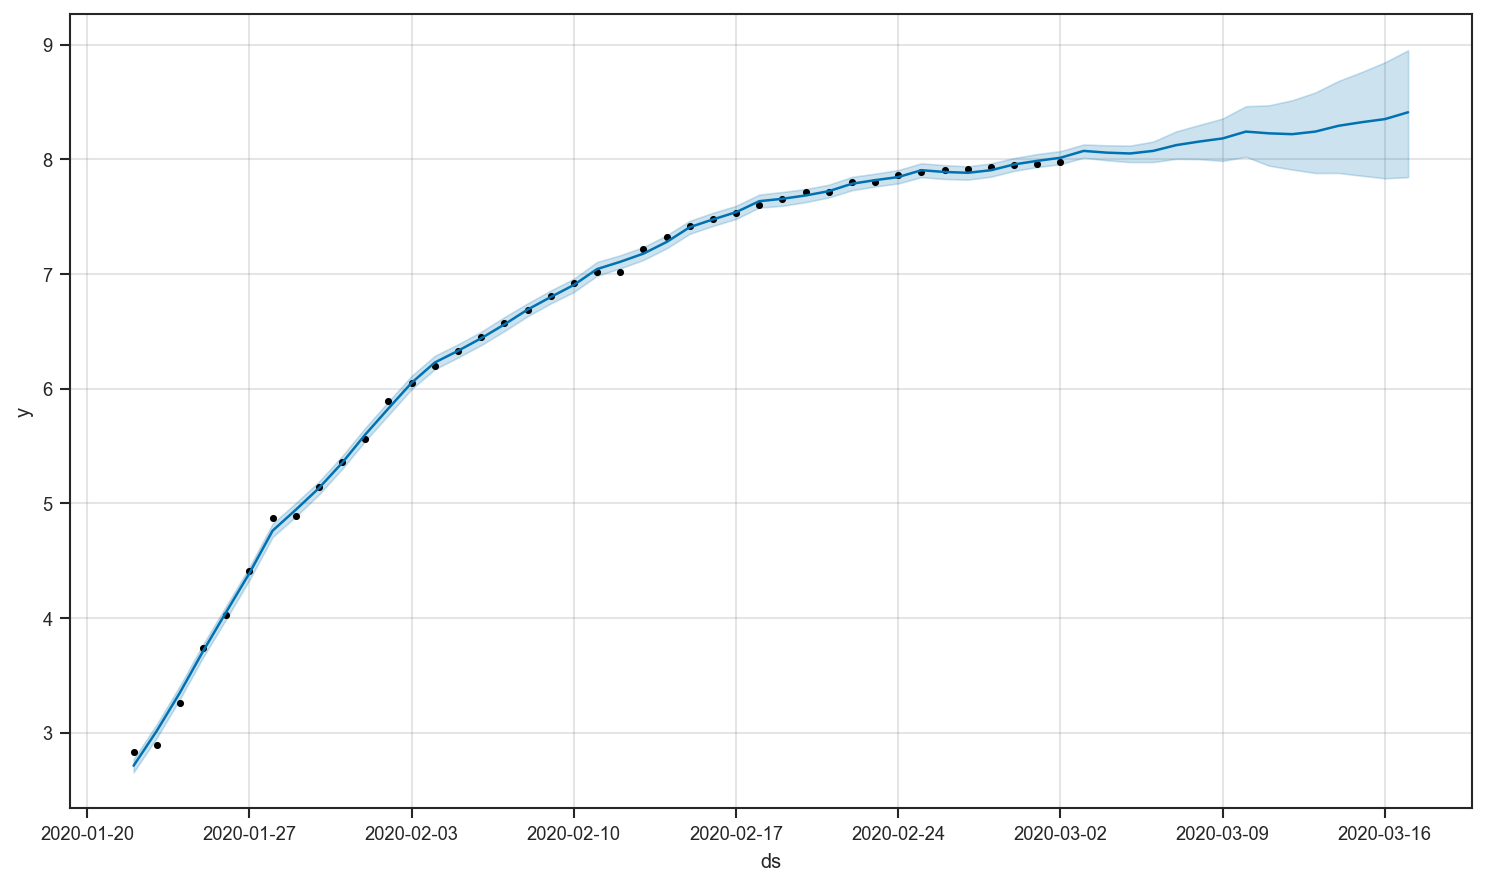

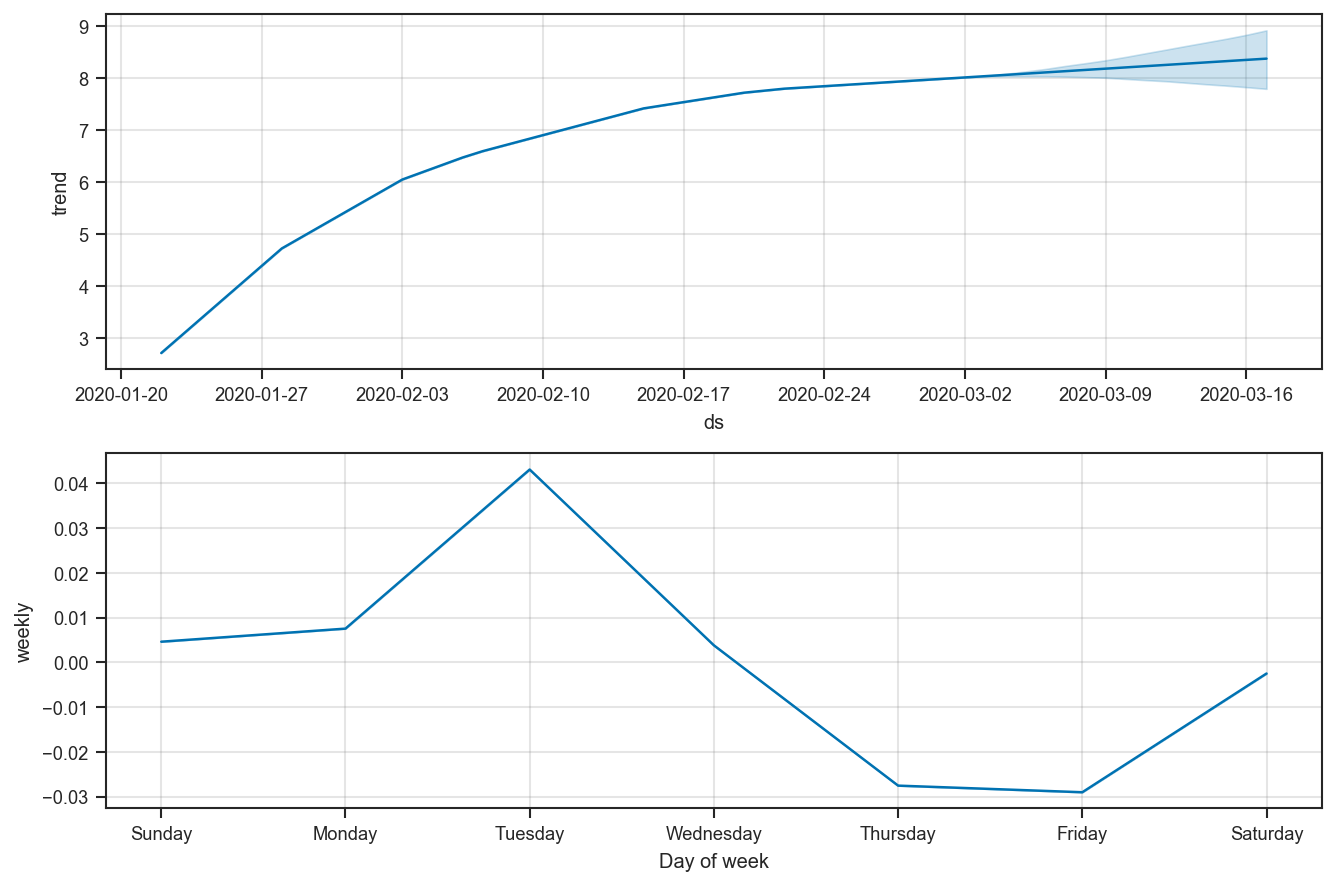

In [207]:
if boxCoxApply: 
    df_pf['y'] = boxcox(df_pf['y'], 0)
m = Prophet()
m.fit(df_pf)
future = m.make_future_dataframe(periods=prediction_size, freq=frequency)
forecast = m.predict(future)
m.plot(forecast);
m.plot_components(forecast);
if boxCoxApply:
    forecast[['yhat']] = inv_boxcox(forecast['yhat'], 0)
    df_pf[['y']] = inv_boxcox(df_pf['y'], 0)

In [208]:
df_china_fc = forecast[['ds','yhat']]
df_china_fc.columns = ['Date', 'Deaths']

In [209]:
df_china_fc.head(2)

Date            Deaths
0 2020-01-22 15.04356743625535
1 2020-01-23 20.38470205672345

In [211]:
fig = go.Figure()
fig.add_trace(go.Line(x=df_china.Date, y=df_china.Deaths, name='Confirmed Deadly Cases'))
fig.add_trace(go.Line(x=df_china_fc.Date, y=df_china_fc.Deaths, name='Deaths Forecast'))

fig.update_layout(
    title="Covid-19 - China Deadly Cases Forecast",
    xaxis_title="Day",
    yaxis_title="# Cases",
    )
fig.show()

### Forecast by Country

In [258]:
def graph_prediction(
        df,
        country,
        value,
        frequency='d',
        prediction_size=15,
        boxCoxApply=True,
):
    df = country_analysis(df, country)
    try:

        df_pf = df[['Date', value]].copy()
        df_pf.columns = ['ds', 'y']

        if boxCoxApply:
            df_pf['y'] = boxcox(df_pf['y'], 0)
        m = Prophet(daily_seasonality=True, yearly_seasonality=False)
        m.fit(df_pf)
        future = m.make_future_dataframe(periods=prediction_size,
                                         freq=frequency)
        forecast = m.predict(future)
        #m.plot(forecast)
        #m.plot_components(forecast)
        if boxCoxApply:
            forecast[['yhat']] = inv_boxcox(forecast['yhat'], 0)
            df_pf[['y']] = inv_boxcox(df_pf['y'], 0)

        df_fc = forecast[['ds', 'yhat']]
        df_fc.columns = ['Date', value]
    except:
        print("\n[INFO] Forecast Calculation not possible")
        df_fc = df

    fig = go.Figure()
    fig.add_trace(
        go.Line(x=df_fc['Date'], y=df_fc[value], name=value + ' Forecast'))
    fig.add_trace(go.Line(x=df['Date'], y=df[value], name=value))

    if value == 'Deaths/Confirmed':
        yaxis_title = "Percentage"
    else:
        yaxis_title = "# Cases"

    fig.update_layout(
        title="Covid-19 - " + country + " " + value + " Cases Prediction",
        xaxis_title="Day",
        yaxis_title=yaxis_title,
    )
    fig.show()

In [253]:
graph_prediction(df, 'China', 'Confirmed')
graph_prediction(df, 'China', 'Deaths')
graph_prediction(df, 'China', 'Deaths/Confirmed')

In [254]:
graph_prediction(df, 'US', 'Confirmed')

In [259]:
graph_prediction(df, 'US', 'Deaths')


[INFO] Forecast Calculation not possible
